In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [85]:
labels = []
with open('./car.label', 'r') as r:
    labels = r.read().strip().split('\n')
labels = [label.split(':')[0] for label in labels]
labels

['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']

In [115]:
df = pd.read_csv('car.data', names=labels)
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


<AxesSubplot: >

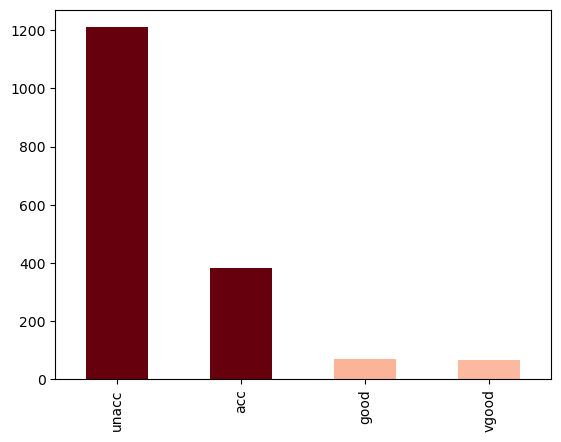

In [169]:
vc = df['class'].value_counts()
vc.plot.bar(color=plt.cm.Reds(vc.values))

In [163]:
plt.cm.coolwarm([1, 10])

array([[0.23437708, 0.30554173, 0.75967953, 1.        ],
       [0.27582712, 0.36671692, 0.81255294, 1.        ]])

In [134]:
df.columns
df.values

array([['vhigh', 'vhigh', '2', ..., 'small', 'low', 'unacc'],
       ['vhigh', 'vhigh', '2', ..., 'small', 'med', 'unacc'],
       ['vhigh', 'vhigh', '2', ..., 'small', 'high', 'unacc'],
       ...,
       ['low', 'low', '5more', ..., 'big', 'low', 'unacc'],
       ['low', 'low', '5more', ..., 'big', 'med', 'good'],
       ['low', 'low', '5more', ..., 'big', 'high', 'vgood']], dtype=object)

In [122]:
from sklearn.preprocessing import LabelEncoder

df_categorical = df.copy(deep=True)
df_categorical.doors = df_categorical.doors.apply(lambda x: 6 if x == '5more' else int(x))
df_categorical.persons = df_categorical.persons.apply(lambda x: 6 if x == 'more' else int(x))
le = LabelEncoder()
le.fit(["low", "med", "high", "vhigh"])
df_categorical.buying = le.transform(df_categorical.buying)
df_categorical.maint = le.transform(df_categorical.maint)
df_categorical.safety = le.transform(df_categorical.safety)

le.fit(['small', 'med', 'big'])
df_categorical.lug_boot = le.transform(df_categorical.lug_boot)


le.fit(["unacc", "acc", "good", "vgood"])
df_categorical['class'] = le.transform(df_categorical['class'])
df_categorical

df_categorical.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,4,4,2,2,3,2,2
1,4,4,2,2,3,3,2
2,4,4,2,2,3,1,2
3,4,4,2,2,2,2,2
4,4,4,2,2,2,3,2


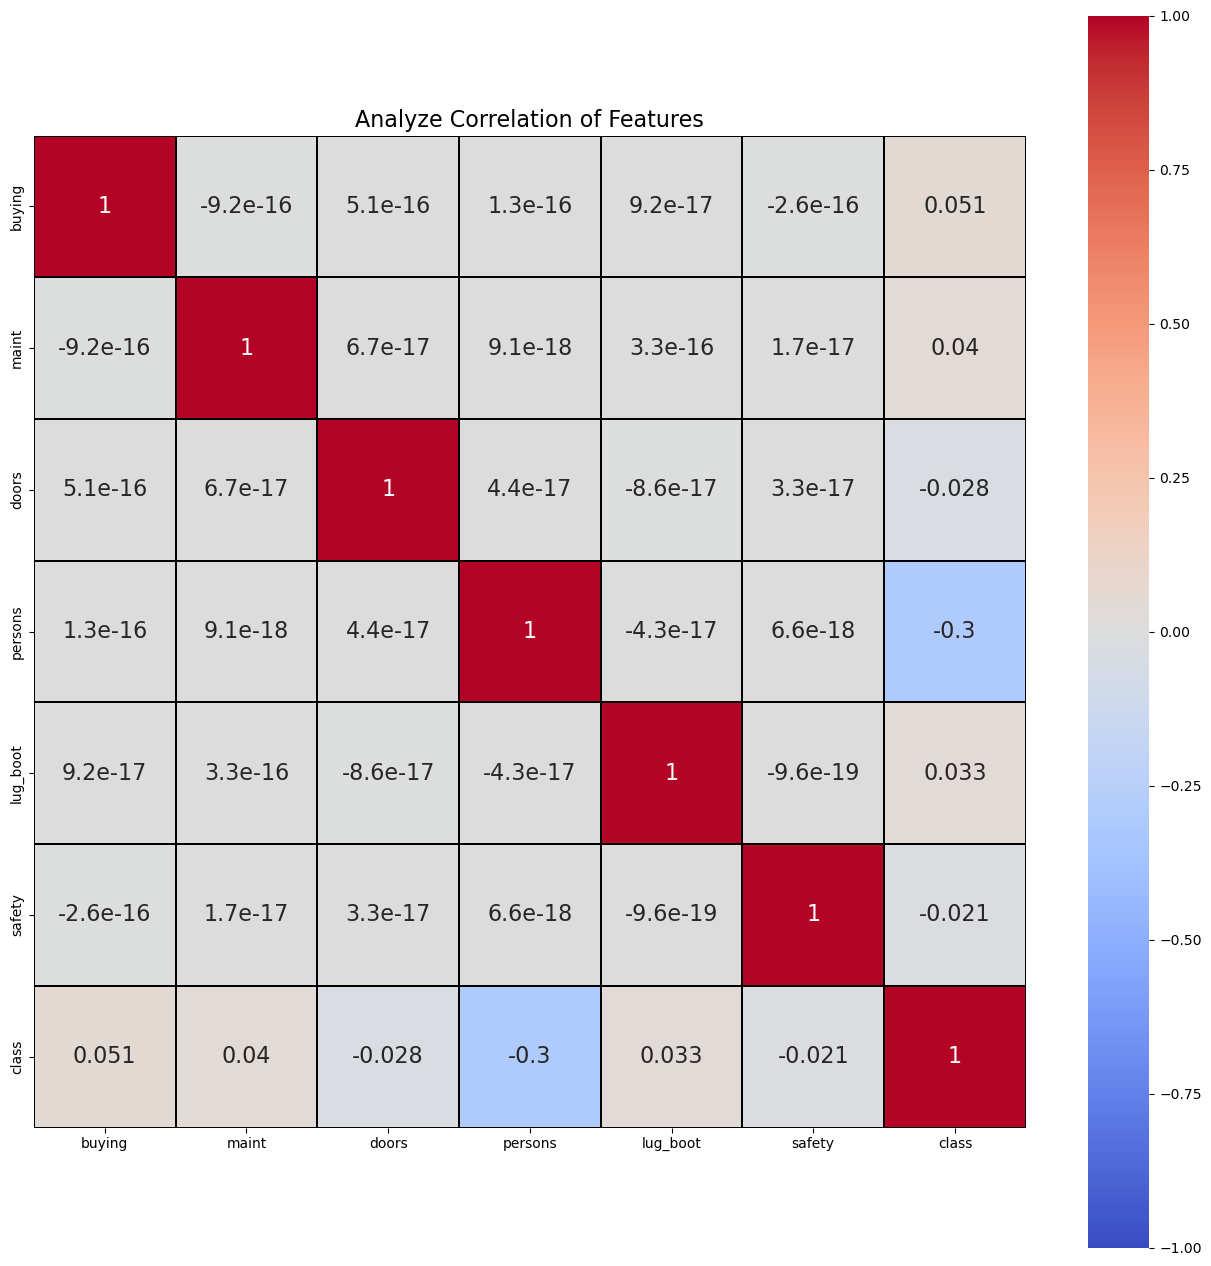

In [123]:
colormap = plt.cm.coolwarm
plt.figure(figsize=(16, 16))
plt.title("Analyze Correlation of Features", y = 1.0, size = 16)
sns.heatmap(df_categorical.astype(float).corr(), linewidths = 0.1, vmin=-1.0, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "black", annot = True, annot_kws = {"size" : 16})
plt.show()

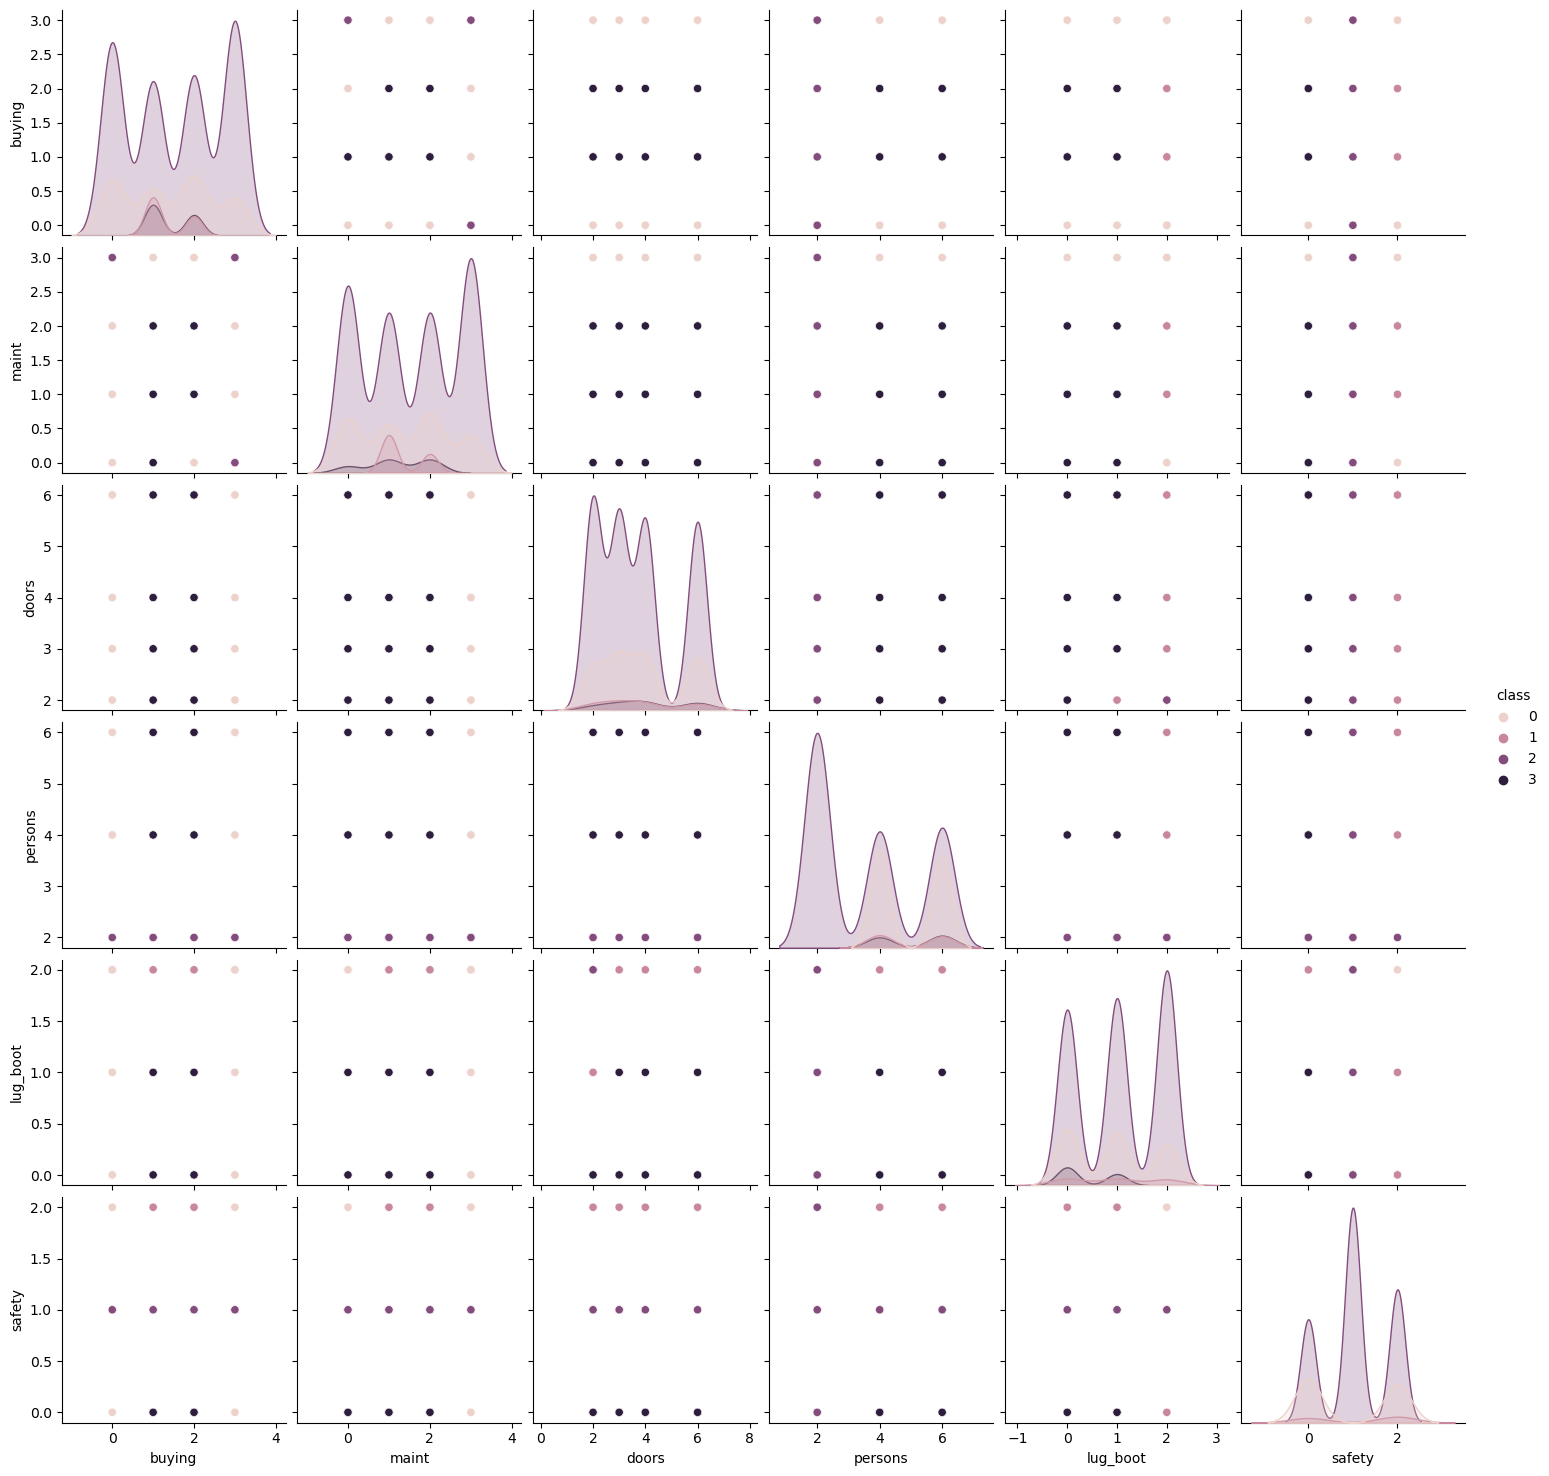

In [120]:
sns.pairplot(df_categorical,
             vars=df_categorical.drop(['class'], axis=1),
            hue ='class')
plt.show()

In [135]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
x = df_categorical.drop(['class'], axis=1).values
x = x.reshape(x.shape[0], 3, 2)
y = to_categorical(df_categorical['class'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1296, 3, 2), (432, 3, 2), (1296, 4), (432, 4))

In [136]:
classes = df['class'].value_counts().keys()
classes

Index(['unacc', 'acc', 'good', 'vgood'], dtype='object')

In [100]:
from tensorflow import keras as ke

In [101]:
model = ke.Sequential()
model.add(ke.layers.Input(x.shape[1:]))
model.add(ke.layers.Conv1D(10, 2, activation=ke.activations.selu))
model.add(ke.layers.MaxPool1D(1, 1))
# model.add(ke.layers.Dropout(0.2))
model.add(ke.layers.Conv1D(10, 2, activation=ke.activations.relu))
model.add(ke.layers.MaxPool1D(1, 1))
model.add(ke.layers.Dropout(0.2))
model.add(ke.layers.Flatten())
model.add(ke.layers.Dense(64, ke.activations.relu))
model.add(ke.layers.Dense(64, ke.activations.relu))
model.add(ke.layers.Dropout(0.2))
model.add(ke.layers.Dense(y.shape[1], ke.activations.softmax))
model.compile(ke.optimizers.legacy.Adam(learning_rate=1e-5), loss=ke.losses.CategoricalCrossentropy(), metrics=["accuracy"])
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_31 (Conv1D)          (None, 2, 10)             50        
                                                                 
 max_pooling1d_19 (MaxPooli  (None, 2, 10)             0         
 ng1D)                                                           
                                                                 
 conv1d_32 (Conv1D)          (None, 1, 10)             210       
                                                                 
 max_pooling1d_20 (MaxPooli  (None, 1, 10)             0         
 ng1D)                                                           
                                                                 
 dropout_22 (Dropout)        (None, 1, 10)             0         
                                                                 
 flatten_4 (Flatten)         (None, 10)              

In [102]:
from tqdm.keras import TqdmCallback
history = model.fit(x_train, y_train, epochs=50, validation_data=(
    x_test, y_test), verbose=0, callbacks=[TqdmCallback(verbose=1)])


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2023-09-15 11:04:11.577489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-15 11:04:13.099490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


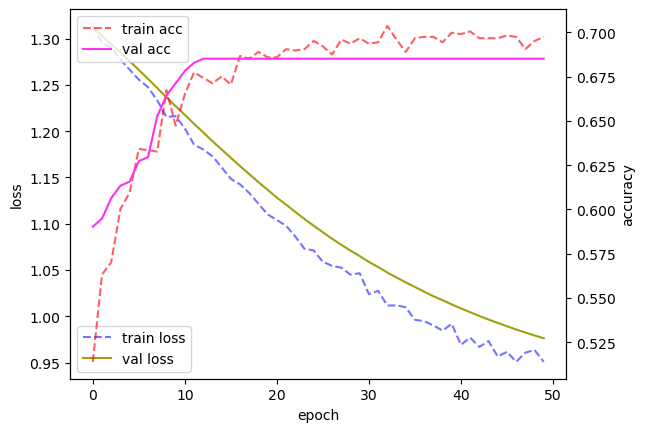

In [103]:
def history_to_graph(hist):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], '#2222ffa0', label='train loss', linestyle='dashed')
    loss_ax.plot(hist.history['val_loss'], '#a0a00f', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='lower left')

    acc_ax.plot(hist.history['accuracy'], '#ff0000a0', label='train acc', linestyle='dashed')
    acc_ax.plot(hist.history['val_accuracy'], '#ff2ff0', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper left')

    plt.show()
history_to_graph(history)

14/14 [==============================] - 0s 5ms/step


(<Figure size 700x700 with 1 Axes>,
 <AxesSubplot: xlabel='predicted label', ylabel='true label'>)

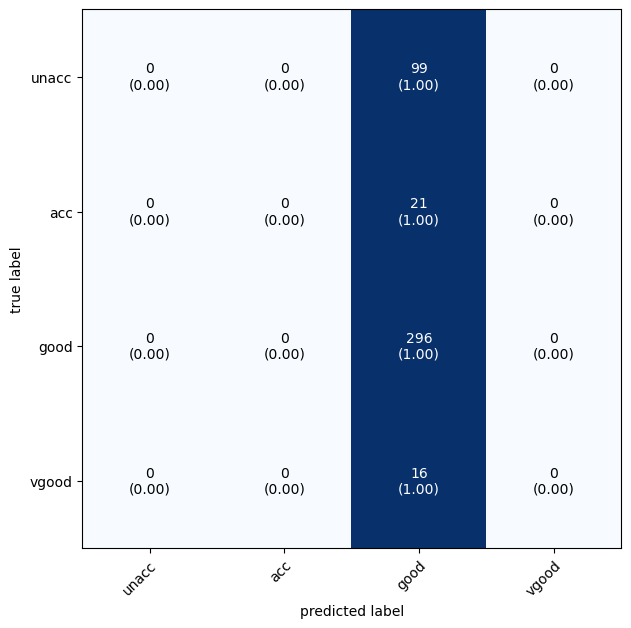

In [148]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

predict_x = model.predict(x_test) 
y_pred_class = np.argmax(predict_x, axis=1)

mat = confusion_matrix(np.argmax(y_test, axis=1), y_pred_class)
plot_confusion_matrix(conf_mat=mat, class_names=classes, show_normed=True, figsize=(7,7))